In [150]:
import sys
import os

# Get the current working directory (where the notebook is located)
curr_dir = os.getcwd()

# Add the project root to the system path
project_root = os.path.abspath(os.path.join(curr_dir, '..'))
sys.path.append(project_root)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from src.LoadEcoCounterData import EcoCounterData as BikeData
import src.Colortheme as ct
from tueplots import bundles
import pandas as pd
import numpy as np

In [151]:
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.framealpha'] = .8
plt.rcParams.update({"figure.dpi": 200})

## Correlation of weather and eco counter data
The goal is to find out, if the weather has an influence on the number of cyclists recorded by the eco counter in Tübingen.
For that we will look at the general weather as well as weather extremes.

### Data preparation

We load the weather data for the years 2015-2023.
We then create a dataframe which only contains the weather from 6am to 6pm, the time we will have a closer look at.

In [153]:
# load WeatherData
from src.LoadWeatherData import WeatherCounterData as WeatherData
wd = WeatherData()

years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

weather_df = wd.get_df(years) # import all year data with local timezone
weather_df = weather_df[weather_df['iso_timestamp'].dt.year > 2014] # filter for years 2015-2023

weather_during_day_df = weather_df[(weather_df['iso_timestamp'].dt.hour >= 6) & (weather_df['iso_timestamp'].dt.hour <= 18)]
weather_during_day_df.head()

,iso_timestamp,temperature,precipitation,Tübingen Snowfall Amount,Tübingen Wind Gust,Tübingen Wind Speed [10 m],Tübingen Wind Direction [10 m],Tübingen Cloud Cover Total,Tübingen Sunshine Duration,year
6,2015-01-01 06:00:00+00:00,-1.940183,0.0,0.0,4.320000,3.617955,174.28941,47.0,0.000000,NaN
7,2015-01-01 07:00:00+00:00,-2.230183,0.0,0.0,7.920000,3.758510,163.30075,41.0,0.000000,NaN
8,2015-01-01 08:00:00+00:00,-1.720183,0.0,0.0,6.840000,3.415260,161.56505,52.0,21.806734,NaN
9,2015-01-01 09:00:00+00:00,-1.740183,0.0,0.0,5.760000,2.520000,180.00000,66.0,19.999998,NaN
10,2015-01-01 10:00:00+00:00,-0.640183,0.0,0.0,6.479999,3.396233,147.99461,95.0,2.424241,NaN


### Prepare Bike Dataset
We group the data but keep the timestamp and counter_side_id. This will sum the channels for each counter.

Then we extract each counter (Fahrradtunnel, Steinlachallee, Hirschau) and merge all of the data into one dataframe to only keep data for timestamps where all data is available.

The columns include now the bike data for the counters Fahrradtunnel, Steinlachallee and Hirschau, as well as the relevant weather data.

In [154]:
bd = BikeData()
bike_data = bd.get_hourly_data()
bike_data.head()

bike_df = bike_data[bike_data["counter_site_id"].isin([100003358, 100003359])]
bike_df = bike_df.groupby(['iso_timestamp'])['zählstand'].mean().reset_index()
bike_df = bike_df[(bike_df['iso_timestamp'].dt.hour >= 6) & (bike_df['iso_timestamp'].dt.hour <= 18)]

# merge to get data that all counters have in common
df_data = bike_df.merge(weather_during_day_df, on='iso_timestamp', how='inner')
df_data.head(2)

,iso_timestamp,zählstand,temperature,precipitation,Tübingen Snowfall Amount,Tübingen Wind Gust,Tübingen Wind Speed [10 m],Tübingen Wind Direction [10 m],Tübingen Cloud Cover Total,Tübingen Sunshine Duration,year
0,2015-01-01 07:00:00+01:00,0.75,-1.940183,0.0,0.0,4.32,3.617955,174.28941,47.0,0.0,NaN
1,2015-01-01 08:00:00+01:00,3.00,-2.230183,0.0,0.0,7.92,3.758510,163.30075,41.0,0.0,NaN


### Calculate peasrson correlation for different weather data and bike data

Correlation of the combined bike counters (Steinlachallee, Fahrradtunnel) and the weather data.

In [155]:
correaltion_df = df_data[['temperature', 'precipitation', 'Tübingen Sunshine Duration', 'Tübingen Snowfall Amount', 'Tübingen Cloud Cover Total']]

correaltion_df.corrwith(df_data['zählstand'], method='pearson').sort_values(ascending=False)

temperature                   0.509729
Tübingen Sunshine Duration    0.277965
Tübingen Snowfall Amount     -0.115085
precipitation                -0.158517
Tübingen Cloud Cover Total   -0.244966
dtype: float64

We observe a moderate positive corrlaation between the number of cyclists and the temperature, weak positive for the sunshine duration and weak negative for the total cloud cover time. The precipitation and snowfall only have a very weak correlation.

### Extract days with extreme weather
For further analysis we extract days with extreme weather conditions. We define extreme weather as:

The 5% of hottest, coldest and rainiest days.

Days with potential black ice (temperature below 0°C and precipitation or snowfall).
The night before is considered for the calculations.

In [156]:
percentile = 0.07
precip_day = df_data.resample('D', on='iso_timestamp').sum()['precipitation']
precip_day_quantil = precip_day.quantile(1-percentile)
precip_day_extreme = precip_day[precip_day > precip_day_quantil]

print("Precipiation considered extreme during day: ", precip_day_quantil, "mm")
print("Maximum precipitation during day: ", precip_day_extreme.max(), "mm")
print("Number of days with extreme precipitation during day: ", len(precip_day_extreme), "days")

Precipiation considered extreme during day:  4.6 mm
Maximum precipitation during day:  35.6 mm
Number of days with extreme precipitation during day:  230 days


In [157]:
temp_day = df_data.resample('D', on='iso_timestamp').mean()['temperature']
hot_day_quantil = temp_day.quantile(1-percentile)
hot_day_extreme = temp_day[temp_day > hot_day_quantil]

print("Temperature considered as extremely hot: ", hot_day_quantil, "°C")
print("Maximum mean temperature during day: ", hot_day_extreme.max(), "°C")
print("Number of days with extreme temperature during day: ", len(hot_day_extreme), "days")

Temperature considered as extremely hot:  24.828689465454545 °C
Maximum mean temperature during day:  32.87436181818182 °C
Number of days with extreme temperature during day:  231 days


In [158]:
cold_day_quantil = temp_day.quantile(percentile)
cold_day_extreme = temp_day[temp_day < cold_day_quantil]

print("Temperature considered as extremely cold: ", cold_day_quantil, "°C")
print("Minimum mean temperature during day: ", cold_day_extreme.min(), "°C")
print("Number of days with extreme temperature during day: ", len(cold_day_extreme), "days")

Temperature considered as extremely cold:  0.9074169438966667 °C
Minimum mean temperature during day:  -9.486016458333333 °C
Number of days with extreme temperature during day:  231 days


Now we calculate potential black ice days.

For data to compare the cyclists behaviour on these days to, we take the in the step before defined normal cold days (20th percentile) and remove the days which are also in the black ice days.

In [159]:
# Group by date and calculate mean temperature, and check for any rain or snow
daily_data = df_data.groupby(df_data['iso_timestamp'].dt.date).agg({
    'temperature': 'mean',
    'precipitation': 'sum',
    'Tübingen Snowfall Amount': 'sum',
    'zählstand': 'sum'
})

# Create a boolean array for the conditions
boolean_array = (daily_data['temperature'] < 0) & ((daily_data['precipitation'] > 0) | (daily_data['Tübingen Snowfall Amount'] > 0))

# Show the boolean array
possible_black_ice_days = daily_data[boolean_array]
possible_black_ice_days.index = pd.to_datetime(possible_black_ice_days.index)

print("Number of days with extreme temperature during day without black ice: ", len(possible_black_ice_days), "days")

Number of days with extreme temperature during day without black ice:  42 days


### Plot the data
We plot the calculated data for the extreme weather days for all the years.
This is done to get a feeling for the data and to see if there are any visual observable patterns.

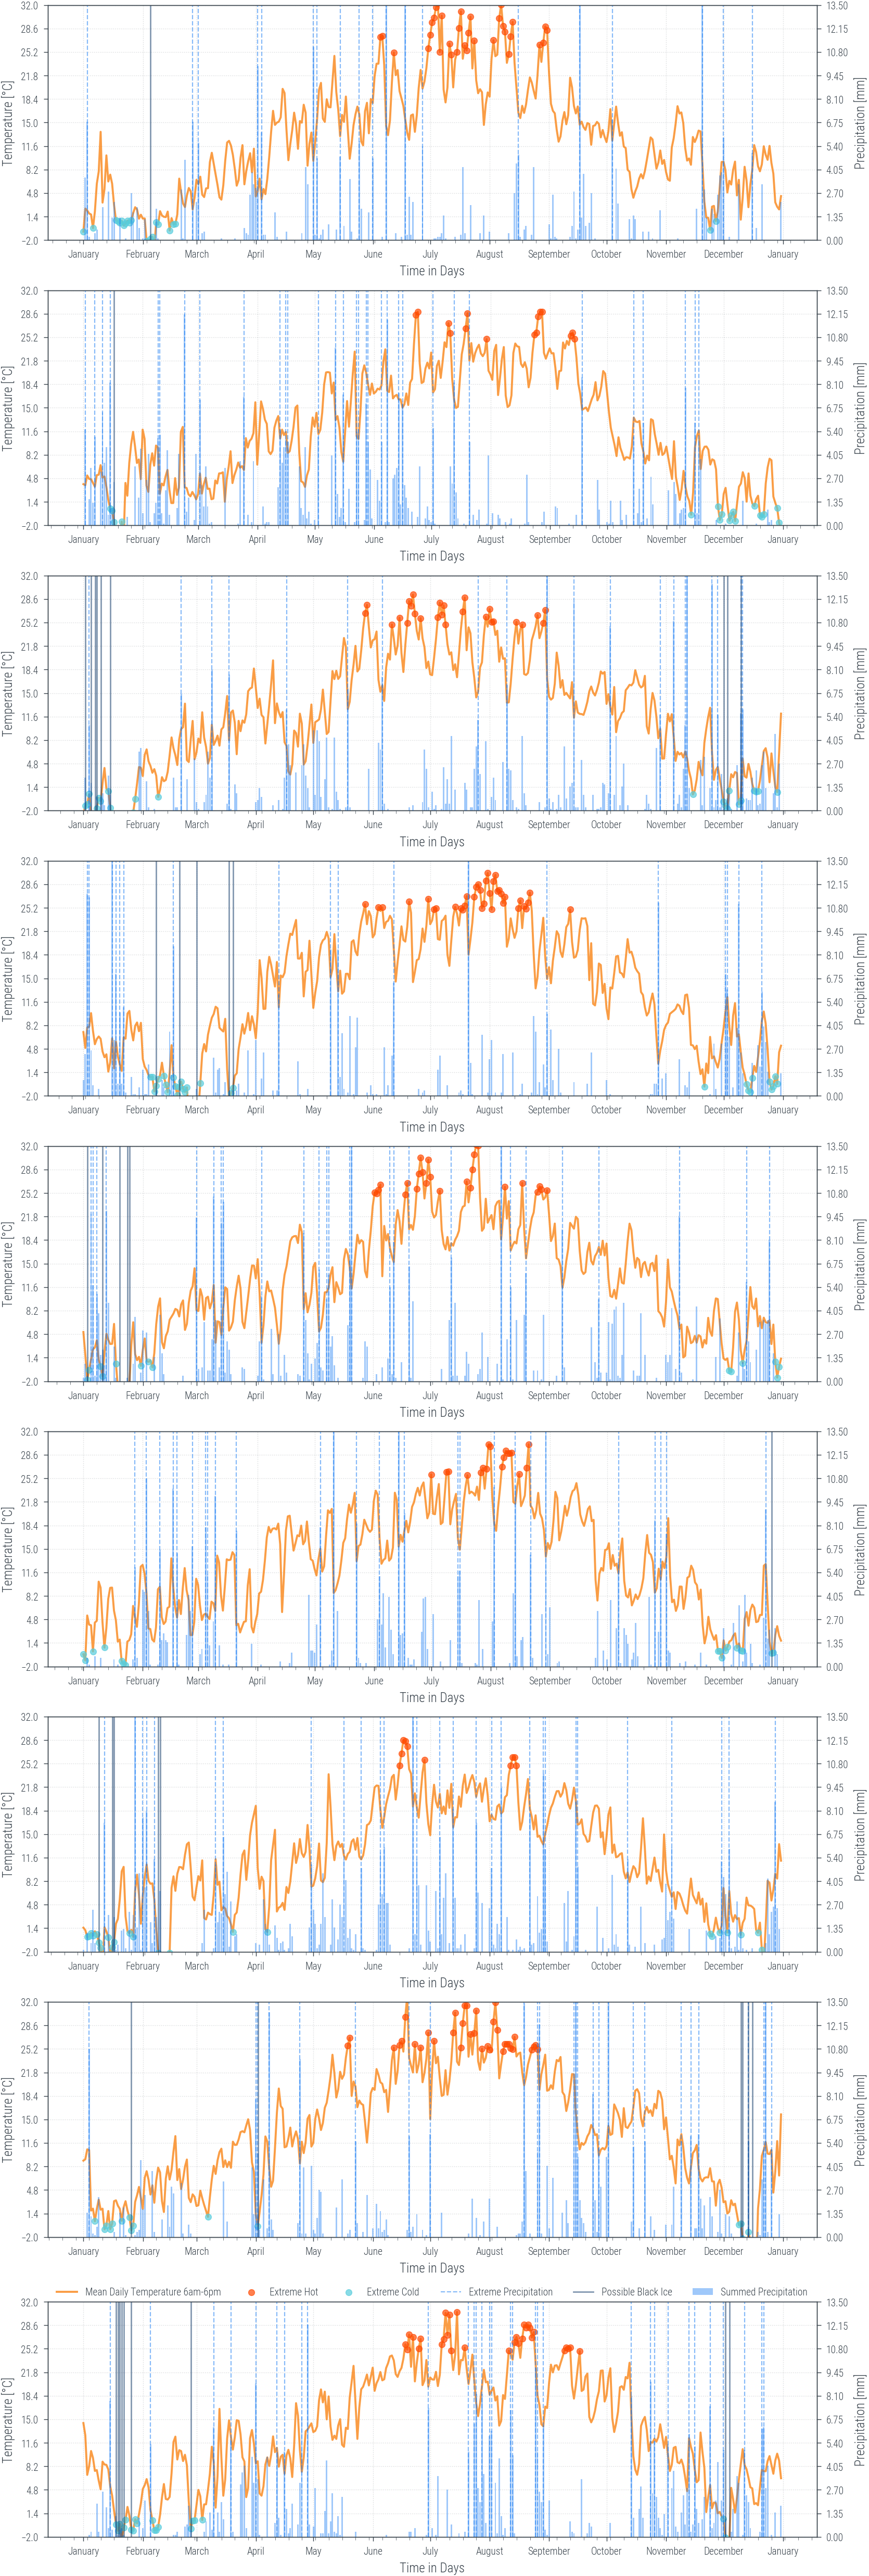

In [160]:
plt.rcParams.update(bundles.beamer_moml(rel_width=1.525, rel_height=8))
ms = 18
fig = plt.figure()
ax=None
plt2=None
for i,year in enumerate(years):
    ax = plt.subplot(9, 1, year - 2014)

    # Plot temperature data
    during_day_temp_mean_year = temp_day[temp_day.index.year == year]
    ax.plot(during_day_temp_mean_year, alpha=0.8, lw=1.4,
            label='Mean Daily Temperature 6am-6pm', linestyle='-', color=ct.TEMP_COLOR)
    
    # Add markers for extreme hot and cold days
    during_day_temp_extreme_hot_year = hot_day_extreme[hot_day_extreme.index.year == year]
    during_day_temp_extreme_cold_year = cold_day_extreme[cold_day_extreme.index.year == year]
    ax.scatter(x=during_day_temp_extreme_hot_year.index,
                y=during_day_temp_extreme_hot_year, alpha=0.7, s=ms, zorder=10,
                color=ct.SUMMER_COLOR, label='Extreme Hot')
    ax.scatter(x=during_day_temp_extreme_cold_year.index,
                y=during_day_temp_extreme_cold_year, alpha=0.7, s=ms,
                color=ct.WINTER_COLOR, label='Extreme Cold', zorder=10)

    # Plot precipitation data
    plt2 = plt.gca().twinx()
    during_day_weather_precip_sum_year = precip_day[precip_day.index.year == year]
    plt2.bar(x=during_day_weather_precip_sum_year.index, alpha=0.4,
            height=precip_day[precip_day.index.year == year],
            label='Summed Precipitation', linestyle='-', color=ct.RAIN_COLOR)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
    # ax.grid(axis="x", which="major")

    # Add markers for extreme precipitation days
    during_day_weather_precip_sum_year = precip_day[precip_day.index.year == year]    
    during_day_precip_extreme_year = precip_day_extreme[precip_day_extreme.index.year == year]
    
    lbl_1 = "Extreme Precipitation"
    for date in during_day_precip_extreme_year.index:
        plt2.axvline(x=date, color=ct.RAIN_COLOR, linestyle='--', alpha=0.5, lw=0.8, label=lbl_1)
        lbl_1 = "_nolegend_"

    possible_black_ice_days_year = pd.to_datetime(possible_black_ice_days.index)[pd.to_datetime(possible_black_ice_days.index).year == year]
    lbl_2 = "Possible Black Ice"
    for date in possible_black_ice_days_year:
        plt2.axvline(x=date, color=ct.RAIN_COLOR*0.4, linestyle='-', alpha=0.5, label=lbl_2)
        lbl_2 = "_nolegend_"
        
    # Add legends

    # Set y-axis labels, limits, and ticks
    ax.set_ylim([-2, 32])
    plt2.set_ylim([0, 13.5])
    ax.set_yticks(np.linspace(-2, 32, 11))
    plt2.set_yticks(np.linspace(0, 13.5, 11))

    # Set axis labels
    ax.set_xlabel('Time in Days')
    ax.set_ylabel('Temperature [°C]')
    plt2.set_ylabel('Precipitation [mm]')

    # Add grid
    ax.grid(ls=":")
    
    
ax.legend(loc="upper left", ncols=3, bbox_to_anchor=(0, 1.1), frameon=False)
plt2.legend(loc="upper right", ncols=3, bbox_to_anchor=(1, 1.1), frameon=False)
plt.show()

Now we do an example plot for the year 2023

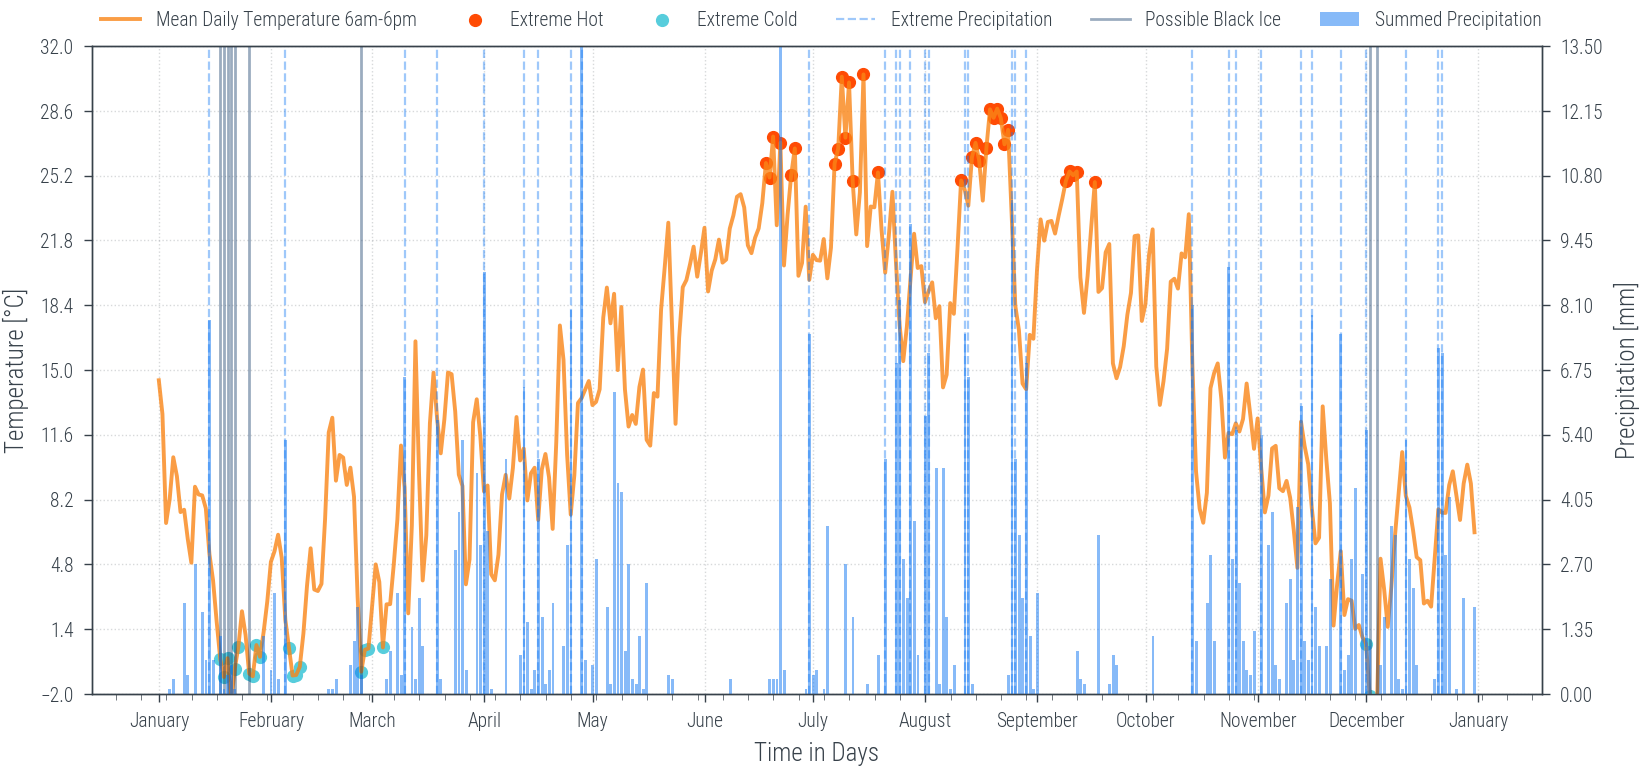

In [161]:
plt.rcParams.update(bundles.beamer_moml(rel_width=1.5, rel_height=1.2))

year = 2023
fig, ax = plt.subplots(1,1)
# fig.suptitle("Mean Daily Temperature in 2023")

# Plot mean temperature data for each day as line plot
during_day_temp_mean_year = temp_day[temp_day.index.year == year]
ax.plot(during_day_temp_mean_year,zorder=11,
         label='Mean Daily Temperature 6am-6pm', linestyle='-', color=ct.TEMP_COLOR, lw=1.4, alpha=0.8)

# Plot precipitation data for each day as bar plot
plt2 = plt.gca().twinx() # this is necessary for second axis!
during_day_weather_precip_sum_year = weather_during_day_df.resample('D', on='iso_timestamp').sum()['precipitation'][weather_during_day_df.resample('D', on='iso_timestamp').sum()['precipitation'].index.year == year]
plt2.bar(x=during_day_weather_precip_sum_year.index, alpha=0.5,
        height=weather_during_day_df.resample('D', on='iso_timestamp').sum()['precipitation'][weather_during_day_df.resample('D', on='iso_timestamp').sum()['precipitation'].index.year == year],
        label='Summed Precipitation', linestyle='-', color=ct.RAIN_COLOR)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
# ax.grid(axis="x", which="major")
lbl_1 = "Extreme Precipitation"
for date in during_day_precip_extreme_year.index:
    plt2.axvline(x=date, color=ct.RAIN_COLOR, linestyle='--', alpha=0.4, lw=0.8, label=lbl_1)
    lbl_1 = "_nolegend_"

possible_black_ice_days_year = pd.to_datetime(possible_black_ice_days.index)[pd.to_datetime(possible_black_ice_days.index).year == year]
lbl_2 = "Possible Black Ice"
for date in possible_black_ice_days_year:
    plt2.axvline(x=date, color=ct.RAIN_COLOR*0.4, linestyle='-', alpha=0.4, label=lbl_2, lw=1, zorder=0)
    lbl_2 = "_nolegend_"

# Add markers for X% of extreme hot days 
during_day_temp_extreme_hot_year = hot_day_extreme[hot_day_extreme.index.year == year]
ax.scatter(x=during_day_temp_extreme_hot_year.index, s=ms,zorder=10,
            y=during_day_temp_extreme_hot_year, alpha=1, color=ct.SUMMER_COLOR, label='Extreme Hot')

# Add markers for X% of extreme cold days
during_day_temp_extreme_cold_year = cold_day_extreme[cold_day_extreme.index.year == year]
ax.scatter(x=during_day_temp_extreme_cold_year.index, s=ms,zorder=10,
            y=during_day_temp_extreme_cold_year, alpha=1, color=ct.WINTER_COLOR, label='Extreme Cold')

fig.legend(loc="upper center", ncols=6, bbox_to_anchor=(.5, 1.05), frameon=False)
# plt2.legend(loc="upper right")
ax_ylim = [-2,32]
ax.set_ylim(ax_ylim)
# ax.set_title("")
# ax.set_title("Mean Daily Temperature in 2023", loc="left")
ax2_ylim = [0,13.5]
plt2.set_ylim(ax2_ylim)
ax.set_yticks(np.linspace(ax_ylim[0], ax_ylim[1], 11))
plt2.set_yticks(np.linspace(ax2_ylim[0], ax2_ylim[1], 11))
ax.set_xlabel('Time in Days')
ax.set_ylabel('Temperature [°C]')
plt2.set_ylabel('Precipitation [mm]')
ax.grid(ls=":")
plt.show()

### Calculating the mean and standard deviation and comparing days with extreme weather to the rest of the days.

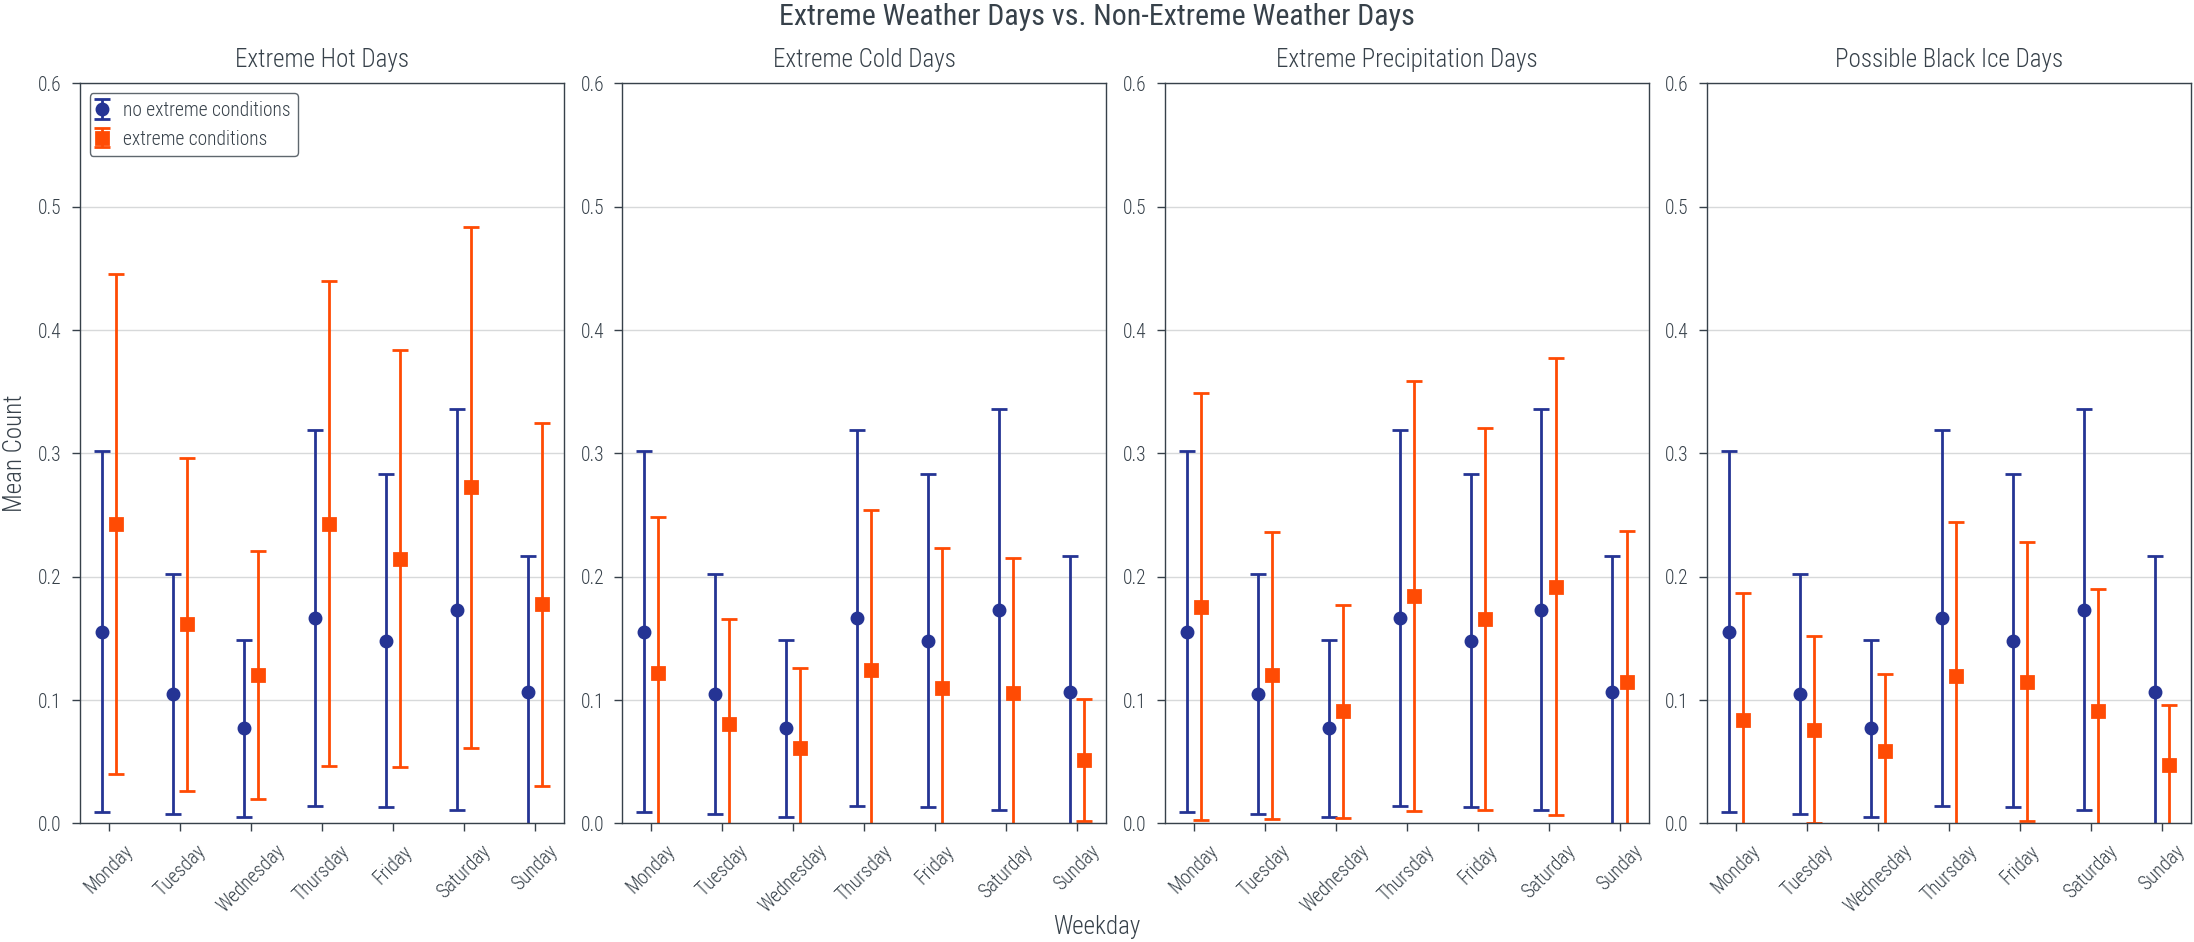

In [162]:
weekday_mapping = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Fahrradtunnel
df_bike = bike_data[bike_data["counter_site_id"].isin([100003358, 100003359])].copy()
# normalize the df at 'zählstand' to 1

zaehlstand_weekday_max = df_bike.groupby(df_bike["iso_timestamp"].dt.weekday)["zählstand"].max()

df_bike["zählstand"] = df_bike.apply(lambda row: row["zählstand"] / zaehlstand_weekday_max[row["weekday"]], axis=1)

df_bike_hot_day_extreme = df_bike[df_bike["iso_timestamp"].dt.date.isin(hot_day_extreme.index.date)]

df_bike_cold_day_extreme = df_bike[df_bike["iso_timestamp"].dt.date.isin(cold_day_extreme.index.date)]

df_bike_precip_day_extreme = df_bike[df_bike["iso_timestamp"].dt.date.isin(precip_day.index.date)]

df_bike_possible_black_ice_days = df_bike[df_bike["iso_timestamp"].dt.date.isin(possible_black_ice_days.index.date)]

df_bike_no_extreme = df_bike[~df_bike["iso_timestamp"].dt.date.isin(hot_day_extreme.index.date)
                             & ~df_bike["iso_timestamp"].dt.date.isin(cold_day_extreme.index.date)
                             & ~df_bike["iso_timestamp"].dt.date.isin(precip_day.index.date)
                             & ~df_bike["iso_timestamp"].dt.date.isin(possible_black_ice_days.index.date)]

df_collection = [[df_bike_no_extreme, df_bike_hot_day_extreme], [df_bike_no_extreme, df_bike_cold_day_extreme], [df_bike_no_extreme, df_bike_precip_day_extreme], [df_bike_no_extreme, df_bike_possible_black_ice_days]]

counter_names = ["Extreme Hot Days", "Extreme Cold Days", "Extreme Precipitation Days", "Possible Black Ice Days"]

plt.rcParams.update(bundles.beamer_moml(rel_width=2, rel_height=1.5))

fig, ax = plt.subplots(1, 4)
for i, data in enumerate(df_collection):
    for d in range(7):
        ax[i].errorbar(
            x=d-0.1,
            y=data[0][data[0]["weekday"] == d]["zählstand"].mean(),
            yerr=data[0][data[0]["weekday"] == d]["zählstand"].std(),
            capsize=3,
            fmt="o",
            ms=4,
            color=ct.PRIMARY_COLORS[0],
            label="no extreme conditions" if d == 0 else "_nolabel_"
        )
        ax[i].errorbar(
            x=d+0.1,
            y=data[1][data[1]["weekday"] == d]["zählstand"].mean(),
            yerr=data[1][data[1]["weekday"] == d]["zählstand"].std(),
            capsize=3,
            fmt="s",
            ms=4,
            color=ct.SUMMER_COLOR,
            label="extreme conditions" if d == 0 else "_nolabel_"
        )
    ax[i].set_title(counter_names[i])
    ax[i].set_xticks(range(7))
    ax[i].set_ylim(bottom=0)
    ax[i].set_ylim(0, 0.6)
    ax[i].grid(axis="y")
    ax[i].set_xticklabels(weekday_mapping, rotation=45)
ax[0].set_ylabel("Mean Count")
fig.text(0.5, -0.01, 'Weekday', ha='center')
plt.suptitle("Extreme Weather Days vs. Non-Extreme Weather Days")
# fig.legend()
leg = ax[0].legend(loc="upper left", handlelength=0.5)
# for l in leg.legendHandles:
#     l.set_linewidth(0.1)
#     l._legmarker.set_markersize(4)
plt.show()

Mean bike counts during the hottest 5% of days exceed those not affected by extreme weather, potentially indicating increased outdoor activity for cooler spaces.

A slight decrease in mean bike counts is noted during the coldest 5% of days on weekdays, suggesting reduced bike presence on extremely cold days.

Interestingly, mean bike counts slightly increase during the rainiest 5% of days compared to the rest of the year.

However, a substantial drop in mean bike counts is observed on days with potential black ice, particularly on Saturdays.

It's important to note the high standard deviations, precluding claims of statistical significance. Nevertheless, discernible variations are apparent.